# Simple Linear Model - OCR
By Gaetano Bonofiglio, Veronica Iovinella

## Introduction
We'll start by developing a simple linear model for classification of handwritten digits (OCR) using MNIST data-set and then plot the results. This will later be compared with a Convolutional Neural Network for the same task.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

tf.__version__

'0.9.0'

## Data Set
The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70.000 images and associated labels. The data-set is split into 3 mutually exclusive sub-sets.

In [3]:
print("Size of")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The data-set has been loaded as so-called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$. For example:

In [4]:
data.test.labels[0:1, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])

We also need the classes as single numbers for various comparisons and performance measures, so we convert the One-Hot encoded vectors to a single number by taking the index of the highest element. Note that the word 'class' is a keyword used in Python so we need to use the name 'cls' instead.

In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
# example
data.test.cls[0:1]

array([7])

### Data dimensions
The data dimensions are used in several places in the source-code below. In computer programming it is generally best to use variables and constants rather than having to hard-code specific numbers every time that number is used. This means the numbers only have to be changed in one single place. Ideally these would be inferred from the data that has been read, but here we just write the numbers.

In [6]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Some plotted images from the data set

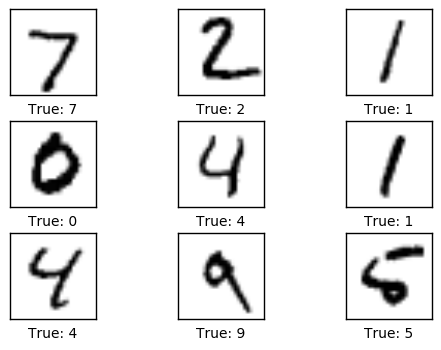

In [8]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph
The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

A TensorFlow graph consists of the following parts which will be detailed below:
- Placeholder variables used to change the input to the graph.
- Model variables that are going to be optimized so as to make the model perform better.
- The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
- A cost measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables of the model.

### Placeholder variables
Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this *feeding the placeholder variables* and it is demonstrated further below.
First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called $tensor$, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to [None, img_size_flat], where *None* means that the tensor may hold an arbitrary number of images with each image being a vector of length *img_size_flat*.

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [10]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

Finally we have the placeholder variable for the true class of each image in the placeholder variable x. These are integers and the dimensionality of this placeholder variable is set to [None] which means the placeholder variable is a one-dimensional vector of arbitrary length.

In [11]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to be optimized
Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.

The first variable that must be optimized is called *weights* and is defined here as a $TensorFlow$ variable that must be initialized with zeros and whose shape is [img_size_flat, num_classes], so it is a 2-dimensional $tensor$ (or *matrix*) with *img_size_flat* rows and *num_classes* columns.

In [12]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

The second variable that must be optimized is called *biases* and is defined as a 1-dimensional $tensor$ (or *vector*) of length *num_classes*.

In [13]:
biases = tf.Variable(tf.zeros([num_classes]))